## 8.1 Regular 1D grids

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import h5py
import scipy.interpolate
from matplotlib import pyplot as plt
from cartopy import crs as ccrs

In [2]:
fires = pd.read_csv("data/VIIRSNDE_global2018312.v1.0.txt")
fires.head()

,Lon,Lat,Mask,Conf,brt_t13(K),frp(MW),line,sample,Sat,YearDay,Hour
0,27.110006,30.769241,8,52,302.877533,5.814295,242,1735,NDE,2018312,1
1,26.083252,30.534357,9,100,332.959717,24.340988,301,1620,NDE,2018312,1
2,34.865997,28.162659,8,38,301.165985,6.107953,396,2589,NDE,2018312,1
3,34.872623,28.161121,8,71,307.277985,9.287819,396,2590,NDE,2018312,1
4,34.865070,28.158880,8,39,301.227783,6.001442,402,2590,NDE,2018312,1


In [3]:
# Number of nx and ny points for the grid. 720 nx, 360 ny creates 1.0 degree grid.
grid_size = 1.0
coverage = [-180.0 , -90.0 , 180.0 , 90.0]

num_points_x = int((coverage[2] - coverage[0])/grid_size)
num_points_y = int((coverage[3] - coverage[1])/grid_size)

print(num_points_x, num_points_y)

360 180


In [4]:
# Using a real step length will skip the end value
print(np.mgrid[0:4:1.0])

# Using a complex number of bins will include the end value
print(np.mgrid[0:4:5j])

[ 0.  1.  2.  3.]
[ 0.  1.  2.  3.  4.]


In [5]:
nx = complex(0, num_points_x)
ny = complex(0, num_points_y)

Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]

In [6]:
fire_count = np.zeros([num_points_x, num_points_y])

for i, lon in enumerate(fires.Lon):
    lat = fires.Lat[i]
    
    adjlat = ((lat + 90) / grid_size);
    adjlon = ((lon + 180 ) / grid_size);
    
    latbin = int(adjlat)
    lonbin = int(adjlon)
    
    fire_count[lonbin, latbin] = fire_count[lonbin, latbin]+1

In [7]:
fire_count[fire_count == 0] = np.nan

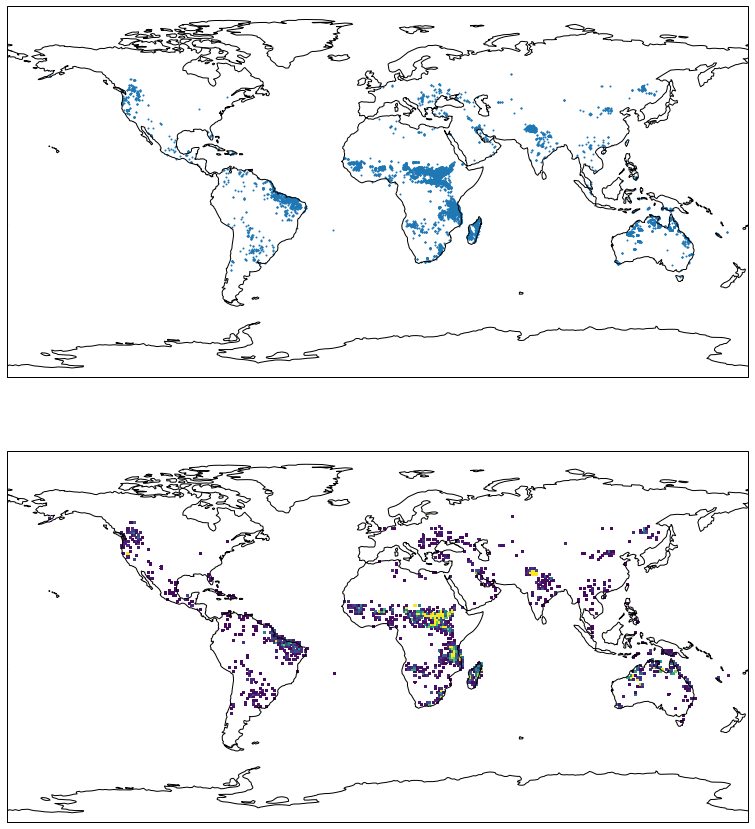

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[15, 15], \
           subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines()
ax1.set_global()
ax1.scatter(fires['Lon'], fires['Lat'], s=1)

ax2.coastlines()
ax2.set_global()

ax2.pcolormesh(Xnew, Ynew, fire_count, vmin=0, vmax=40)

plt.show()

## 8.2 Regular 2D grids

In [9]:
fname = 'data/3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B.HDF5'
imergv6 = h5py.File(fname, 'r')

precip = imergv6['Grid/precipitationCal'][0,:,:]
lat = imergv6['Grid/lat'][:]
lon = imergv6['Grid/lon'][:]

In [10]:
Xold, Yold = np.meshgrid(lon, lat, indexing='ij')

In [11]:
# Number of nx and ny points for the grid. 720 nx, 360 ny creates 1.0 degree grid.
def createGlobalGrid(grid_size):
    coverage = [-180.0 , -90.0 , 180.0 , 90.0]

    num_points_x = int((coverage[2] - coverage[0])/grid_size)
    num_points_y = int((coverage[3] - coverage[1])/grid_size)

    nx = complex(0, num_points_x)
    ny = complex(0, num_points_y)

    Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]
    return Xnew, Ynew

In [12]:
Xnew, Ynew = createGlobalGrid(0.5)

In [13]:
precip.shape, Yold.shape, Ynew.shape

((3600, 1800), (3600, 1800), (720, 360))

In [14]:
values = precip.flatten()

dims = (values.shape[0], 2)
points =  np.zeros(dims)

points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

In [15]:
gridOut = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')

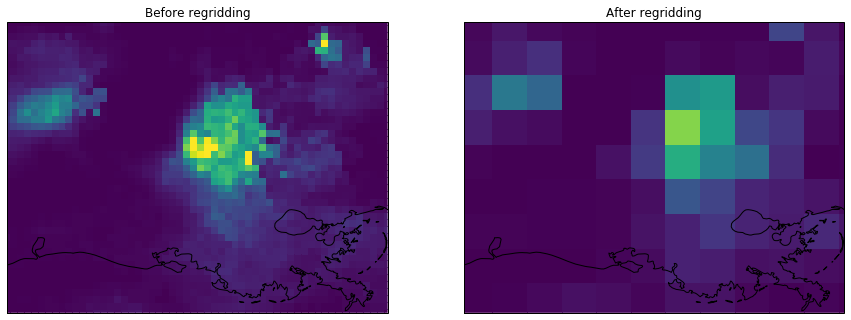

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=[15, 15], \
   subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.set_extent([-94.3, -88.8, 28.9, 33.1])
    ax.coastlines('10m', color='black')

axes[0].set_title("Before regridding")
axes[0].pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)

axes[1].set_title("After regridding")
axes[1].pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=20)

plt.show()

In [17]:
## Irregular 2D grids
### Resizing

In [18]:
fname = "data/goes-meso/michael/OR_ABI-L1b-RadM1-M3C02_G16_s20182822019282_e20182822019339_c20182822019374.nc"
g16nc = Dataset(fname, 'r')
C02 = g16nc.variables['Rad'][:,:]

In [19]:
proj_var = g16nc.variables['goes_imager_projection']

sat_height = proj_var.perspective_point_height
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis
central_lon = proj_var.longitude_of_projection_origin

# Multiply the x, y coordinated by satellite height to get the pixel position
X = g16nc.variables['x'][:] * sat_height
Y = g16nc.variables['y'][:] * sat_height
imgExtent = (X.min(), X.max(), Y.min(), Y.max())

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

In [20]:
resized_C02 = C02[::20, ::20]

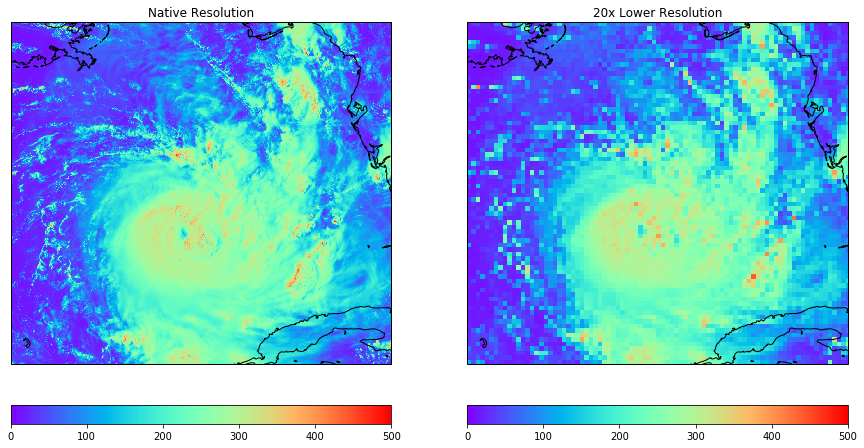

In [21]:
lims = [0, 500]
fig, axes = plt.subplots(ncols=2,  figsize=[15, 15], \
     subplot_kw={'projection': crs})

for ax in axes:
    ax.set_extent([-90.0, -82.0, 22.0, 30.0])
    ax.coastlines('10m', color='black')

axes[0].set_title("Native Resolution")
im1 = axes[0].imshow(C02, cmap=plt.get_cmap("rainbow"), extent=imgExtent, \
     vmin=lims[0], vmax=lims[1])

axes[1].set_title("20x Lower Resolution")
im2 = axes[1].imshow(resized_C02, cmap=plt.get_cmap("rainbow"), extent=imgExtent, \
     vmin=lims[0], vmax=lims[1])

# Adding colorbars
fig.colorbar(im1, pad=0.05, orientation='horizontal', ax=axes[0])
fig.colorbar(im2, pad=0.05, orientation='horizontal', ax=axes[1])

plt.show()

### Resampling

In [22]:
from pyresample import geometry
from pyresample.kd_tree import resample_nearest

In [23]:
fname='data/JRR-AOD_v1r1_npp_s201808091955538_e201808091957180_c201808092049460.nc'
file_id_NPP = Dataset(fname)

aod = file_id_NPP.variables['AOD550'][:,:]
lat = file_id_NPP.variables['Latitude'][:,:]
lon = file_id_NPP.variables['Longitude'][:,:]

In [24]:
# Input list of swath points
oldLonLat = geometry.SwathDefinition(lons=lon, lats=lat)

In [25]:
# Create a new grid at 0.1 degree resolution
x = np.arange(lon.min(), lon.max(), 0.1)
y = np.arange(lat.min(), lat.max(), 0.1)
newLon, newLat = np.meshgrid(x, y)

In [26]:
# define the new grid using 
newLonLat = geometry.GridDefinition(lons=newLon, lats=newLat)

In [27]:
# Resample the data
newAOD = resample_nearest(oldLonLat, aod, newLonLat, radius_of_influence=5000, fill_value=None)

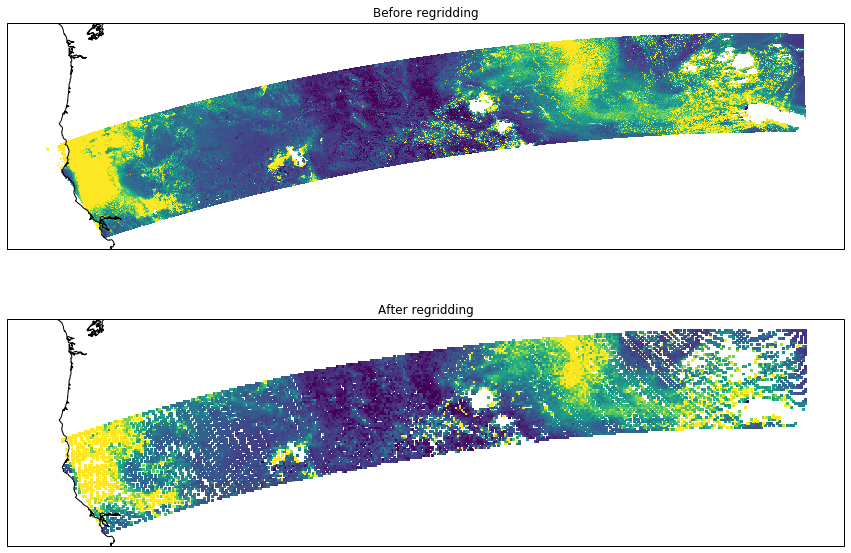

In [28]:
lims = [0,1]
fig, axes = plt.subplots(nrows=2,  figsize=[15, 10], \
     subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.coastlines('10m', color='black')

axes[0].set_title("Before regridding")
axes[0].pcolormesh(lon, lat, aod, vmin=lims[0], vmax=lims[1])

axes[1].set_title("After regridding")
axes[1].pcolormesh(newLon, newLat, newAOD, vmin=lims[0], vmax=lims[1])

plt.show()